LMDB 全称为 Lightning Memory-Mapped Database，就是非常快的内存映射型数据库，LMDB使用内存映射文件，可以提供更好的输入/输出性能，对于用于神经网络的大型数据集( 比如 ImageNet )，可以将其存储在 LMDB 中。

https://zhuanlan.zhihu.com/p/70359311
http://www.lmdb.tech/doc/index.html
https://lmdb.readthedocs.io/en/release/

LMDB属于key-value数据库，而不是关系型数据库( 比如 MySQL )，LMDB提供 key-value 存储，其中每个键值对都是我们数据集中的一个样本。LMDB的主要作用是提供数据管理，可以将各种各样的原始数据转换为统一的key-value存储。

LMDB效率高的一个关键原因是它是基于内存映射的，这意味着它返回指向键和值的内存地址的指针，而不需要像大多数其他数据库那样复制内存中的任何内容。

LMDB不仅可以用来存放训练和测试用的数据集，还可以存放神经网络提取出的特征数据。如果数据的结构很简单，就是大量的矩阵和向量，而且数据之间没有什么关联，数据内没有复杂的对象结构，那么就可以选择LMDB这个简单的数据库来存放数据。

LMDB的文件结构很简单，一个文件夹，里面是一个数据文件和一个锁文件。数据随意复制，随意传输。它的访问简单，不需要单独的数据管理进程。只要在访问代码里引用LMDB库，访问时给文件路径即可。

# 用LMDB数据库来存放图像数据，而不是直接读取原始图像数据的原因

数据类型多种多样，比如：二进制文件、文本文件、编码后的图像文件jpeg、png等，不可能用一套代码实现所有类型的输入数据读取，因此通过LMDB数据库，转换为统一数据格式可以简化数据读取层的实现。
lmdb具有极高的存取速度，大大减少了系统访问大量小文件时的磁盘IO的时间开销。LMDB将整个数据集都放在一个文件里，避免了文件系统寻址的开销，你的存储介质有多快，就能访问多快，不会因为文件多而导致时间长。LMDB使用了内存映射的方式访问文件，这使得文件内寻址的开销大幅度降低。

# 图片数据示例

在图像深度学习训练中我们一般都会把大量原始数据集转化为lmdb格式以方便后续的网络训练。因此我们也需要对该数据集进行lmdb格式转化。

将图片和对应的文本标签存放到lmdb数据库：

In [1]:
!pip install lmdb

In [2]:
import lmdb
image_path = '../images/test_images/0.jpg'
label = 'beauty'

env = lmdb.open('lmdb_dir')
cache = {}  # 存储键值对
with open(image_path, 'rb') as f:
    # 读取图像文件的二进制格式数据
    image_bin = f.read()
    
# 用两个键值对表示一个数据样本
#这里需要获取图像文件的二进制格式数据，然后用两个键值对保存一个数据样本，即分开保存图片和其标签。
cache['image_000'] = image_bin
cache['label_000'] = label

with env.begin(write=True) as txn:
    for k, v in cache.items():
        if isinstance(v, bytes):
            # 图片类型为bytes
            txn.put(k.encode(), v)
        else:
            # 标签类型为str, 转为bytes
            txn.put(k.encode(), v.encode())  # 编码

env.close()

从lmdb数据库中读取图片数据：

<class 'numpy.ndarray'>
(5331,)
<class 'numpy.ndarray'>


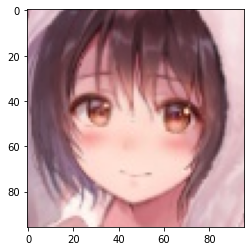

In [3]:
import cv2
import lmdb
import numpy as np
from matplotlib import pyplot as plt

env = lmdb.open('lmdb_dir') #创建一个 lmdb 环境

with env.begin(write=False) as txn:
    # 获取图像数据
    image_bin = txn.get('image_000'.encode())
    label = txn.get('label_000'.encode()).decode()  # 解码
    
    #print(type(image_bin)) #<class 'bytes'>
    # 将二进制文件转为十进制文件（一维数组）
    image_buf = np.frombuffer(image_bin, dtype=np.uint8)
    print(type(image_buf)) #<class 'numpy.ndarray'>
    print(image_buf.shape) #(5331,)
    # 将数据转换(解码)成图像格式
    # cv2.IMREAD_GRAYSCALE为灰度图，cv2.IMREAD_COLOR为彩色图
    img = cv2.imdecode(image_buf, cv2.IMREAD_COLOR)
    img = img[:, :, [2, 1, 0]]  # bgr => rgb 由于使用cv读取出来的图片是bgr格式的，因此需要转换为rgb格式
    print(type(img))
    plt.imshow(img)
    #print(img.shape)
    #cv2.imshow('image', img)
    #cv2.waitKey(0)